In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    assert 0 <= k and k < len(k_indices)
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = np.delete(x, k_indices[k])
    y_train = np.delete(y, k_indices[k])
    
    x_test = build_poly(x_test, degree)
    x_train = build_poly(x_train, degree)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************
    w = ridge_regression(y_train, x_train, lambda_)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    # ***************************************************
    loss_tr = compute_mse(y_train, x_train, w)
    loss_te = compute_mse(y_test, x_test, w)
    return loss_tr, loss_te

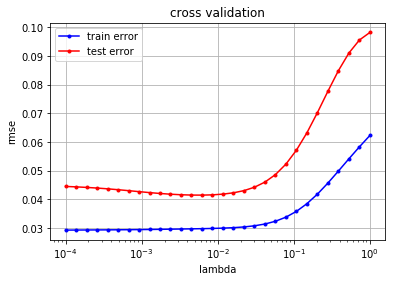

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    tr_data = []
    te_data = []
    for lambda_ in lambdas:
        k_rmse_tr = []
        k_rmse_te = []
        for k in range(len(k_indices)):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            k_rmse_tr.append(loss_tr)
            k_rmse_te.append(loss_te)
        rmse_tr.append(np.mean(k_rmse_tr))
        rmse_te.append(np.mean(k_rmse_te))
        tr_data.append(k_rmse_tr)
        te_data.append(k_rmse_te)
        
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    return (tr_data, te_data)

tr_data, te_data =  cross_validation_demo()

Text(0.5,1,'Cross Validation Mean & Variance')

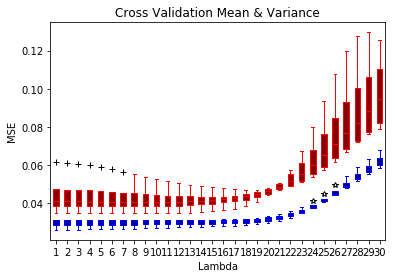

In [6]:
def draw_plot(data, edge_color, fill_color, sym):
    bp = plt.boxplot(data, patch_artist=True, sym=sym)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)  

draw_plot(te_data, 'red', 'darkred', '+')
draw_plot(tr_data, 'blue', 'darkblue', '*')
plt.ylabel("MSE")
plt.xlabel("Lambda")
plt.title("Cross Validation Mean & Variance")

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

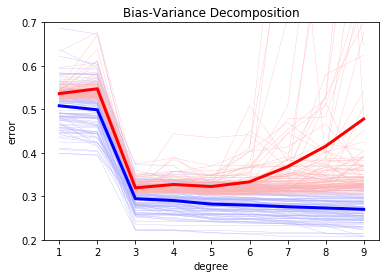

In [23]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        x_train, y_train, x_test, y_test = split_data(x, y, ratio_train, seed)
        for index_degree, degree in enumerate(degrees):
            tx_train = build_poly(x_train, degree)
            tx_test = build_poly(x_test, degree)
            tr_loss, w = least_squares(y_train, tx_train)
            rmse_tr[index_seed][index_degree] = np.sqrt(2 * compute_mse(y_train, tx_train, w))
            rmse_te[index_seed][index_degree] = np.sqrt(2 * compute_mse(y_test, tx_test, w))
            
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()

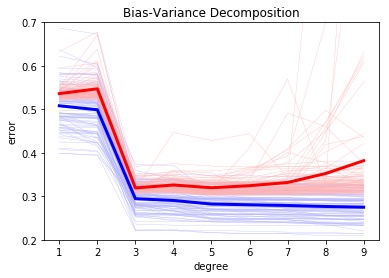

In [38]:
def bias_variance_ridge_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    k_fold = 4
    lambdas = np.logspace(-4, 4, 30)
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        x_train, y_train, x_test, y_test = split_data(x, y, ratio_train, seed)
        for index_degree, degree in enumerate(degrees):
            tx_train = build_poly(x_train, degree)
            tx_test = build_poly(x_test, degree)
            losses = []
            for lambda_ in lambdas:
                w = ridge_regression(y_train, tx_train, lambda_)
                losses.append(compute_mse(y_train, tx_train, w))
            best_lambda = lambdas[np.argmin(losses)]
            w = ridge_regression(y_train, tx_train, best_lambda)
            rmse_tr[index_seed][index_degree] = np.sqrt(2 * compute_mse(y_train, tx_train, w))
            rmse_te[index_seed][index_degree] = np.sqrt(2 * compute_mse(y_test, tx_test, w))
            
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_ridge_demo()